In [1]:
#実験に使用するファイルとmacアドレスを指定する
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import linear_sum_assignment
import numpy as np
import sys
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

useData = pd.read_csv('data/capture/ver3/useData.csv')
print(useData.fileName)


0    g7_walk_05_1.csv
1    g7_walk_05_2.csv
2    g7_walk_05_3.csv
3    g7_walk_05_4.csv
4    g7_walk_05_5.csv
Name: fileName, dtype: object


In [2]:
#元データを読み取る
original=[]
number=0
for fileName in useData.fileName:
    df =pd.read_csv('data/capture/ver3/masterPiece/'+fileName)
    df.replace(df.address[0],"address"+str(number),inplace=True)
    original.append(df)
    number +=1
#print(original)

In [3]:
# 元データからMACアドレスの変化データを作成
changed = []
addressList=[]
for data in original:
    before = []
    after = []
    afterFirst = 999

    for line in data.itertuples():
        if float(line.time) <= 5:
            before.append(line)
        elif 5 <= float(line.time) and afterFirst == 999:
            afterFirst = float(line.time)
        elif float(line.time) - afterFirst <= 5:
            modified_address = line.address + "_2"
            line = line._replace(address=modified_address)
            after.append(line)
        else:
            break
    changed.append(before)
    addressList.append(before[0].address)
    changed.append(after)
    addressList.append(after[0].address)
print(addressList)
# for data in changed:
#     for line in data:
#         print(line)
#     print()


['address0', 'address0_2', 'address1', 'address1_2', 'address2', 'address2_2', 'address3', 'address3_2', 'address4', 'address4_2']


In [4]:
#パケットの受信時刻をフォーマット
#変化タイミングを0にそろえる
def studyC(changed):
    for data in changed:
        if not "_2" in data[0].address:
            beforeLast=float(data[len(data)-1].time)
            #print(beforeLast)
        for i, line in enumerate(data):
            data[i] = line._replace(time=str(float(line.time) - beforeLast))
#         print(data[i])
# print(changed)

In [5]:
#モデルを用意
def regression(model,changed):
    models={}
    for data in changed:
        #print(data[0].address)
        x_train=[]
        y_train=[]
        for line in data:
            x_train.append(float(line.time))
            y_train.append(float(line.rssi))
        clf = model
        clf.fit(pd.DataFrame(x_train),y_train)
        models[data[0].address]=clf
        assignment_table=[]
    for data in changed:
        assignment_line=[]
        for data2 in changed:
            diff =float(data2[0].time)-float(data[len(data)-1].time)
            if data[0].address != data2[0].address and 0 <= diff and diff<= 6:
                x_test=[]
                for line in data2:
                    x_test.append(line.time)
                predict=models[data[0].address].predict(pd.DataFrame(x_test))
                sum=0
                for i in range(len(data2)):
                    sum+=abs(data2[i].rssi-predict[i])
                assignment_line.append(sum/len(data2))
            else:
                assignment_line.append(sys.float_info.max)
        assignment_table.append(assignment_line)
    return assignment_table

#print(models)

In [6]:
def timeDiff(changed):
    assignment_table=[]
    for data in changed:
        assignment_line=[]
        for data2 in changed:
            diff =float(data2[0].time)-float(data[len(data)-1].time)
            if data[0].address != data2[0].address and 0 <= diff and diff<= 6:
                assignment_line.append(diff)
            else:
                assignment_line.append(sys.float_info.max)
        assignment_table.append(assignment_line)
    return assignment_table


In [7]:
#関数呼び出し
#ここでデータをずらしたり割り当てを行う
liner=LinearRegression(fit_intercept = True, copy_X = True, n_jobs = -1)
svr=svm.SVR(kernel='poly')
#assignment_table= regression(liner,changed)
studyC(changed)
assignment_table1= regression(svr,changed)
assignment_table2= timeDiff(changed)

bias=0.0
for i in range(len(assignment_table1)):
    for j in range(len(assignment_table1[i])):
        assignment_table1[i][j] *= bias

# # Add the two matrices element-wise

assignment_table = np.add(assignment_table1, assignment_table2)
for i in range(len(assignment_table)):
    for j in range(len(assignment_table[i])):
        if assignment_table[i][j]==float('inf'):
             assignment_table[i][j]=sys.float_info.max

In [8]:
def addressInfo(address,change):
    for data in change:
        if data[0].address==address:
            print(address+" "+"ftime= "+ str(data[0].time)+",ltime="+str(data[len(data)-1].time))
            break

In [9]:
# 線形割り当て


row_ind, col_ind = linear_sum_assignment(np.array(assignment_table))
print(row_ind)
print(col_ind)
isTrue = 0
for i in row_ind:
    if assignment_table[i][col_ind[i]] != sys.float_info.max:
        addressInfo(addressList[i], changed)
        print(addressList[i] + " is matched " + addressList[col_ind[i]])
        addressInfo(addressList[col_ind[i]], changed)
        print("cost is " + str(assignment_table[i][col_ind[i]]))
    else:
        print(addressList[i] + " is not matched", end=" ")
    if i % 2 == 0 and i + 1 == col_ind[i]:
        print(True)
        isTrue += 1
    elif i % 2 == 1:
        print("\n")
    else:
        print(False)

accuracy = isTrue / float(len(addressList) / 2)
print("accuracy is " + str(accuracy))


[0 1 2 3 4 5 6 7 8 9]
[5 0 3 6 7 2 9 4 1 8]
address0 ftime= -4.304990999997244,ltime=0.0
address0 is matched address2_2
address2_2 ftime= 2.003682000009576,ltime=5.1512930000026245
cost is 2.003682000009576
False
address0_2 is not matched 

address1 ftime= -4.29511900000216,ltime=0.0
address1 is matched address1_2
address1_2 ftime= 2.561186999999336,ltime=5.14751399999659
cost is 2.561186999999336
True
address1_2 is not matched 

address2 ftime= -3.1462269999901764,ltime=0.0
address2 is matched address3_2
address3_2 ftime= 2.5798829999985173,ltime=3.7223740000044927
cost is 2.5798829999985173
False
address2_2 is not matched 

address3 ftime= -3.7225069999985863,ltime=0.0
address3 is matched address4_2
address4_2 ftime= 3.4124020000017476,ltime=6.271094000010635
cost is 3.4124020000017476
False
address3_2 is not matched 

address4 ftime= -2.581257999991067,ltime=0.0
address4 is matched address0_2
address0_2 ftime= 3.4424740000104066,ltime=6.595032000011997
cost is 3.4424740000104066
Fal

In [10]:
# プロット用の関数
def graph(before, after, correct):
    bTime = []
    bRssi = []
    for packet in before:
        bTime.append(float(packet.time))
        bRssi.append(packet.rssi)
    aTime = []
    aRssi = []
    for packet in after:
        aTime.append(float(packet.time))
        aRssi.append(packet.rssi)
    cTime = []
    cRssi = []
    for packet in correct:
        cTime.append(float(packet.time))
        cRssi.append(packet.rssi)
#     # X軸の数字をオフセットを使わずに表現する
#     plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
#     plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
    # グラフの描画設定
#     plt.rcParams['pdf.fonttype'] = 42
#     plt.rcParams['font.size'] = 16
#     plt.rcParams['axes.labelsize'] = 19
#     plt.rcParams['axes.titlesize'] = 24
#     plt.rcParams['xtick.labelsize'] = 20
#     plt.rcParams['ytick.labelsize'] = 20

#     plt.rcParams['legend.fontsize'] = 20
#     plt.rcParams['legend.loc'] = 'lower right'

#     plt.rcParams['figure.figsize'] = (8, 6)
#     plt.rcParams['figure.dpi'] = 100

    plt.xlabel("Time")
    plt.ylabel("RSSI")
    plt.ylim(-65, -100)

    minx = float(bTime[0]) - 1
    maxx = float(aTime[len(aTime) - 1]) + 1

    # X軸のメモリを1刻みに設定
    x_ticks = np.arange(int(minx), int(maxx) + 1,1)
    print(x_ticks)
    plt.xticks(x_ticks)
    

    plt.plot(bTime, bRssi, linewidth=6, label="before")
    plt.plot(aTime, aRssi, linewidth=6, label="after",)
    plt.plot(cTime, cRssi, linewidth=6, label="correct")
    plt.legend(bbox_to_anchor=(0, -0.1), loc='upper left', borderaxespad=0, fontsize=18)

    plt.title(before[0].address)
  
    plt.show()

[-5 -4 -3 -2 -1  0  1  2  3  4  5  6  7]


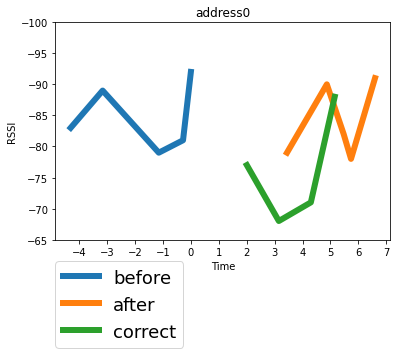

[-5 -4 -3 -2 -1  0  1  2  3  4  5  6]


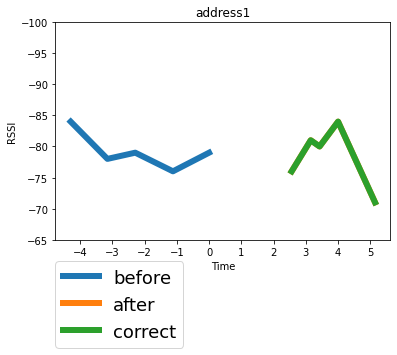

[-4 -3 -2 -1  0  1  2  3  4  5  6]


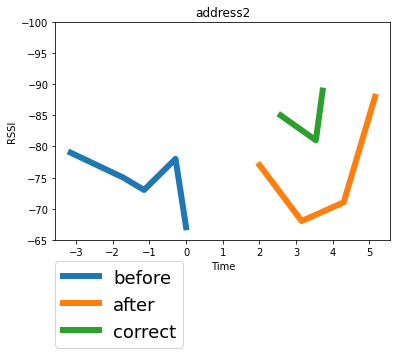

[-4 -3 -2 -1  0  1  2  3  4]


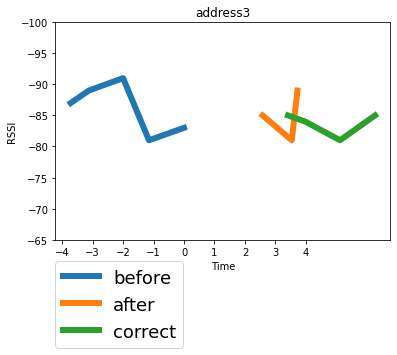

[-3 -2 -1  0  1  2  3  4  5  6  7]


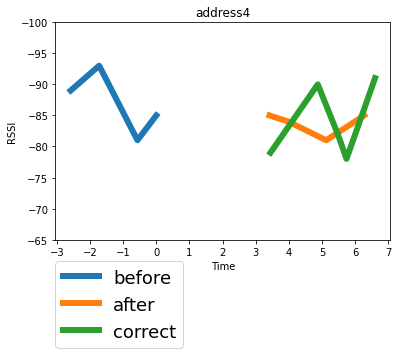

In [11]:

# graph(changed[0],changed[1],changed[col_ind[0]])
for i in row_ind:
    if i%2==0:
        graph(changed[i],changed[i+1],changed[col_ind[i]])
        
        